**Create Hexbins of a given city and export population,tree canopy, temperature, cooling etc maps. **

In [68]:
# Import packages
import geopandas as gpd , os 
import  seaborn as sn
import geemap 
import ee 
import rasterio
from rasterio.mask import mask
import osmnx as ox
from shapely.geometry import box
from rasterio.plot import show
import pylab as plt
from geopandas.tools import sjoin
import contextily as cx
from h3 import h3
import h3pandas
from rasterstats import zonal_stats
import pandas as pd
import numpy as np
from rasterio.crs import CRS
import matplotlib.colors as colors
import warnings
warnings.filterwarnings("ignore")

# Stats heavy-lifting
from esda.moran import Moran
from libpysal.weights import Queen, KNN
from sklearn import metrics
from sklearn.preprocessing import robust_scale
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering



In [69]:
def set_paths(base_dir):
    data = os.path.join(base_dir, 'data') 
    output = os.path.join(base_dir, 'output') 
    shapefiles = os.path.join(output, 'shapefiles') 
    maps = os.path.join(output, 'maps') 
    rasters = os.path.join(output, 'rasters') 
    
    dirs_list= [ shapefiles , maps , rasters]
    for dir in dirs_list:
        if not os.path.exists(dir):
            os.mkdir(dir)

    return shapefiles , maps , rasters

base_dir = 'C:/Users/Aziz/Dropbox/CRP/UHI'
shapefiles , maps , rasters= set_paths(base_dir)

Initialize ee and import shapefile and select city

In [70]:
ee.Initialize()
# run_uh_analysis=True
run_uh_analysis=False
WGS84=4326 #uses degrees
WGS84_meters=3857 #uses meters
EPSG_str= 'EPSG:4326'
city= "Phnom Penh"
gdf_WA = gpd.read_file(f'{shapefiles}/khm_admbnda_adm1_gov_20181004.shp').to_crs(WGS84)
gdf_WA=gdf_WA[gdf_WA["ADM1_EN"] == city]
country= gdf_WA.iloc[0]['ADM0_EN']


In [71]:
# subcity level. District, tehsil and Union council
#Function for subnation overlay and stats export. Rank and percentiles. EWNS comparative anlalysis. 
# Run an ols and export the table and key message. Do this in step 2 
gdf_subcity = gpd.read_file(f'{shapefiles}/khm_admbnda_adm3_gov_20181004.shp').to_crs(WGS84)
gdf_subcity=gdf_subcity[gdf_subcity["ADM1_EN"] == city]
gdf_subcity.shape

(96, 17)

In [39]:
def create_hexbins_and_geom_features(gdf_WA, hexbin_res, WGS84):
    poly = gdf_WA.geometry.unary_union
    gdf_boundary = gpd.GeoDataFrame(geometry=[poly],crs=gdf_WA.crs)
    # gdf_h3 = gdf_boundary.h3.polyfill(9,explode=True)
    gdf_h3 = gdf_boundary.h3.polyfill(hexbin_res,explode=True)
    gdf_h3 = gdf_h3.set_index('h3_polyfill').h3.h3_to_geo_boundary()
    output_shapefile= f'{shapefiles}/h3_grid.shp'
    gdf_h3.to_file(output_shapefile)
    hexbins_projected = gpd.read_file(output_shapefile).to_crs(WGS84)

    geom = gdf_boundary['geometry']
    jsonDict = eval(geom.to_json())
    for index, row in gdf_boundary.iterrows(): 
        polygon_list= []
        for x in jsonDict['features'][index]['geometry']['coordinates']:
            polygon_list.append(x)
            region = ee.Geometry.Polygon(polygon_list)
            fc_filtered = ee.FeatureCollection(region)
            
    gdf_h3.plot()

    return fc_filtered  , region , hexbins_projected

In [40]:
#Import the clipped tree cover and uhi rasters and export the export polgonize these before feeding them to the algos 
# that follow. Repeat the process with zonal stating at subcity levels
# Fundamental of bank operations
# Beginer and Advanced 

def zonal_stats_trees_and_pop_for_subcity(ee , EPSG_str, fc_filtered, region, subcity_shapefile):

    tree_cover=ee.ImageCollection("projects/sat-io/open-datasets/GFCC30TC") \
        .limit(1, 'system:time_start', False).first().clip(fc_filtered)

    tif = os.path.join(rasters, 'tree_cover_projected.tif')
    geemap.ee_export_image(
        tree_cover, filename=tif,  
        crs=EPSG_str,
        # crs_transform=crs_transform,
        scale=30, region=region, file_per_band=False
    )

    # add zonal stats to the hexbin gpd dataframe and replace nans with 0 
    subcity_shapefile['tree_cover_sum'] = zonal_stats(subcity_shapefile, tif ,stats='sum')
    subcity_shapefile['tree_cover_sum'] = [item['sum'] for item in subcity_shapefile['tree_cover_sum']]
    subcity_shapefile['tree_cover_sum'].fillna(0,inplace=True)
    max=int(subcity_shapefile.loc[subcity_shapefile['tree_cover_sum'].idxmax()]['tree_cover_sum'])
    subcity_shapefile['Percentile Rank'] = subcity_shapefile.tree_cover_sum.rank(pct = True, ascending=False)
    
    pop_density = ee.ImageCollection("WorldPop/GP/100m/pop").map(clipToCol). \
                    filterDate('2020').select('population').mosaic()

    tif = os.path.join(rasters, 'pop_density_projected.tif')
    geemap.ee_export_image( pop_density, 
                           filename=tif,  
                           crs=EPSG_str,
                           # crs_transform=crs_transform,
                           scale=100, 
                           region=region, 
                           file_per_band=False
                           )

    # add zonal stats to the hexbin gpd dataframe and replace nans with 0 
    subcity_shapefile['pop_density_sum'] = zonal_stats(subcity_shapefile, tif ,stats='sum')
    subcity_shapefile['pop_density_sum'] = [item['sum'] for item in subcity_shapefile['pop_density_sum']]
    subcity_shapefile['pop_density_sum'].fillna(0,inplace=True)
    max=int(subcity_shapefile.loc[subcity_shapefile['pop_density_sum'].idxmax()]['pop_density_sum'])
    
    return subcity_shapefile 

Generating URL ...
Please wait ...
Data downloaded to C:\Users\Aziz\Dropbox\CRP\UHI\output\rasters\tree_cover_projected.tif
Generating URL ...
Please wait ...
Data downloaded to C:\Users\Aziz\Dropbox\CRP\UHI\output\rasters\pop_density_projected.tif


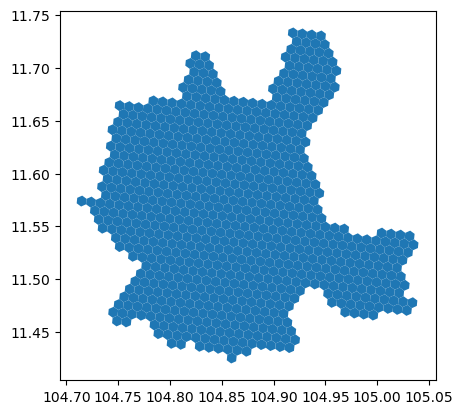

In [41]:
if __name__ == "__main__":
    fc_filtered  , region , hexbins_projected= create_hexbins_and_geom_features(gdf_WA, hexbin_res=8, WGS84=WGS84)
    subcity_zonal_stats= zonal_stats_trees_and_pop_for_subcity(ee , EPSG_str, fc_filtered=fc_filtered, region=region, subcity_shapefile=gdf_subcity)


In [72]:
# subcity_zonal_stats
# PS: EPSG:4326 is using degrees as units, try the EPSG:3857 which uses meters as unit or 
# if you know the location of your polygons choose a projection from a national grid

db = subcity_zonal_stats 
db =db.to_crs(WGS84_meters)
db['area_sqm'] = db.geometry.area
cluster_variables = ["tree_cover_sum",  # sum of tree cover 
                     "pop_density_sum",  # sum of pop cover 
                     ]


In [123]:
db[cluster_variables]

,tree_cover_sum,pop_density_sum
67,244746.0,9711.628906
114,10679.0,14697.952148
115,11838.0,22587.517578
118,5623.0,20742.416016
119,8579.0,19225.875000
...,...,...
1602,4733.0,17255.923828
1603,2551.0,14531.288086
1612,76138.0,10975.711914
1614,6249.0,24110.515625


Quick map function

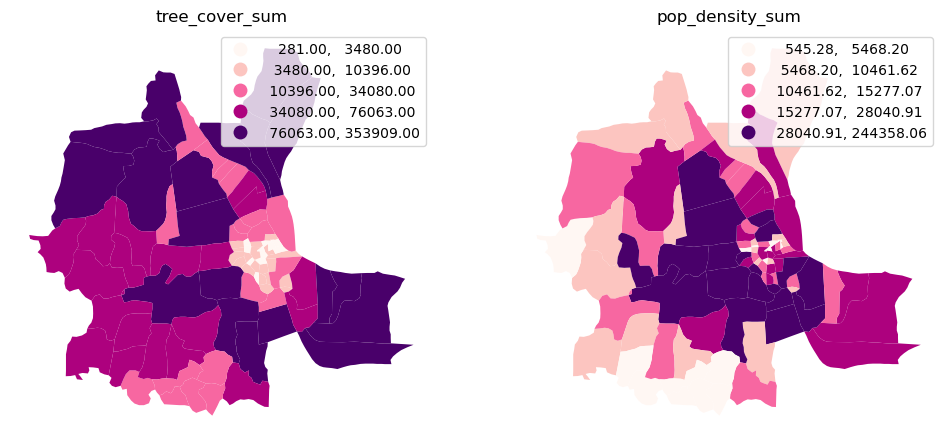

In [73]:
f, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    db.plot(
        column=col,
        ax=ax,
        scheme="Quantiles",
        linewidth=0,
        cmap="RdPu",
        legend=True,
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
    # plt.legend( fontsize = 'x-small')


# handles, labels = axs.get_legend_handles_labels()
# f.legend(handles, labels, loc='upper center')
# plt.legend(loc=2, fontsize = 'x-small')
# Display the figure
plt.show()

As spatial autocorrelation affect the spatial structure of resulting clusters, calculate 
Moran's I as it measures global spatial autocorrelation.

In [74]:
# Create the spatial weights matrix that gives us spatial configuration of each pixel 
w = Queen.from_dataframe(db)
# Set seed for reproducibility
np.random.seed(123456)
# Calculate Moran's I for each variable in the cluster var
mi_results = [
    Moran(db[variable], w) for variable in cluster_variables
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(cluster_variables, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table #P value of less than .05 means that spatail structure exists. confirms non-randomness

,Moran's I,P-value
Variable,,
tree_cover_sum,0.528678,0.001
pop_density_sum,0.269061,0.002


We need to explore correlation between pop and tree cover not just Spatial Autocorrelation>>>>means some spatial structure exists. P values is less than .05.
In the pair plots below on the
diagonal we have the density functions for each var and shows the univariate distribution each var.
The one shifted to the right are refered to as negatively skewed and vice versa.

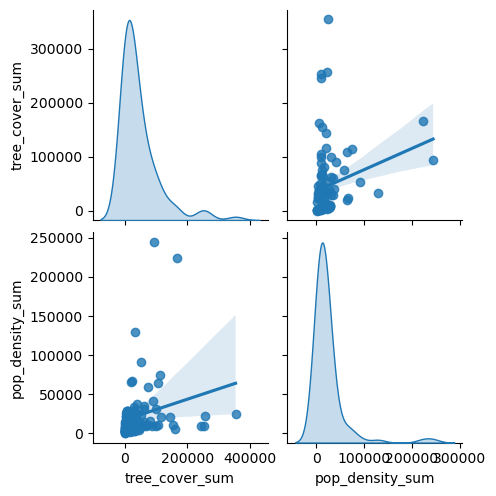

In [75]:
bivariate_plots_for_corr = sn.pairplot(
    db[cluster_variables], kind="reg", diag_kind="kde"
)


Both are +ve skewed. Confrims of autocorr as shown in Moran I. Both are concentrated around origin. 

In [76]:
db_scaled = robust_scale(db[cluster_variables])
# Initialize KMeans instance
kmeans = KMeans(n_clusters=5)
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db_scaled)
# Print first five labels
k5cls.labels_[:5]

array([4, 3, 0, 3, 3])

Plot the kmeans clusters

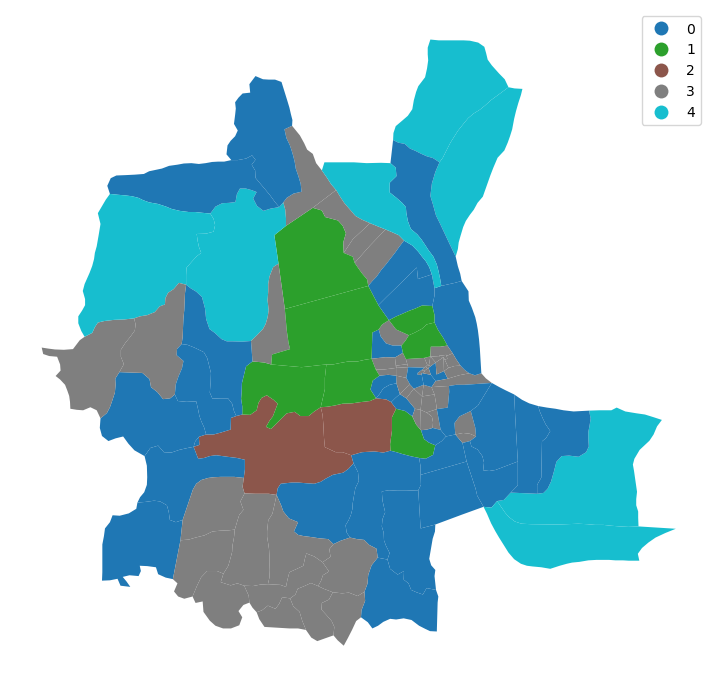

In [77]:
# Assign labels into a column
db["k5cls"] = k5cls.labels_
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
db.plot(
    column="k5cls", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [78]:
# Group data table by cluster label and count observations
k5sizes = db.groupby("k5cls").size()
k5sizes

k5cls
0    30
1     7
2     2
3    50
4     7
dtype: int64

 `dissolve` will combine all tracts belonging to each cluster into a single
polygon object. Then we will report the total land area of each of the n clusters.

In [79]:
# Dissolve areas by Cluster, aggregate by summing,
# and keep column for area
areas = db.dissolve(by="k5cls", aggfunc="sum")["area_sqm"]
areas

k5cls
0    2.623927e+08
1    7.415572e+07
2    3.980520e+07
3    1.473698e+08
4    1.941456e+08
Name: area_sqm, dtype: float64

Cluster counts versus their total areas

In [ ]:
# Bind cluster figures in a single table
area_tracts = pd.DataFrame({"No. Tracts": k5sizes, "Area": areas})
# Convert raw values into percentages
area_tracts = area_tracts * 100 / area_tracts.sum()
# Bar plot
ax = area_tracts.plot.bar()
# Rename axes
ax.set_xlabel("Cluster labels")
ax.set_ylabel("Percentage by cluster");

In [80]:
cluster_1_pct= areas[1] / areas.sum()
cluster_1_pct

0.10329979022626944

To build a basic profile, we will compute the averages of each of the vars in every cluster. Use unscaled because we can interpret these. Scaled ones are hard to wrap our human minds around

In [81]:
# Group table by cluster label, keep the variables used
# for clustering, and obtain their mean
k5means = db.groupby("k5cls")[cluster_variables].mean()
# Transpose the table and print it rounding each value
# to three decimals
k5means.T.round(3)

k5cls,0,1,2,3,4
tree_cover_sum,50049.000,60978.857,130549.500,12552.120,224171.571
pop_density_sum,22874.901,78666.442,233854.281,8486.012,14761.652


Get detail summaries of each of the these vars by the clsuters

In [82]:
#-----------------------------------------------------------#
# Illustrative code only, not executed
#-----------------------------------------------------------#
# Group table by cluster label, keep the variables used 
# for clustering, and obtain their descriptive summary
k5desc = db.groupby('k5cls')[cluster_variables].describe()
# Loop over each cluster and print a table with descriptives
for cluster in k5desc.T:
    print('\n\t---------\n\tCluster %i'%cluster)
    print(k5desc.T[cluster].unstack())
#-----------------------------------------------------------#


	---------
	Cluster 0
                 count          mean           std          min           25%  \
tree_cover_sum    30.0  50049.000000  34450.940165  3227.000000  16172.250000   
pop_density_sum   30.0  22874.901335   9334.299128  9141.552734  14660.237793   

                         50%           75%            max  
tree_cover_sum   50013.50000  73943.000000  116625.000000  
pop_density_sum  23705.65625  29209.164062   41782.839844  

	---------
	Cluster 1
                 count          mean           std           min          25%  \
tree_cover_sum     7.0  60978.857143  39015.701034  20176.000000  28085.50000   
pop_density_sum    7.0  78666.441964  24545.472930  58671.351562  65055.84375   

                          50%           75%           max  
tree_cover_sum   53107.000000  91890.000000  113618.00000  
pop_density_sum  66751.203125  83057.722656  129015.40625  

	---------
	Cluster 2
                 count          mean           std       min            25%  \
tree

Reshape the profiles data. 

In [83]:
# Index db on cluster ID
tidy_db = db.set_index("k5cls")
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)
# Check out result
tidy_db.head()

,k5cls,Attribute,Values
0,4,tree_cover_sum,244746.000000
1,4,pop_density_sum,9711.628906
2,3,tree_cover_sum,10679.000000
3,3,pop_density_sum,14697.952148
4,0,tree_cover_sum,11838.000000


Visualize the data above. Get density distribution of each cluster's values for each variable. This gives us the full distributional profile of each cluster:

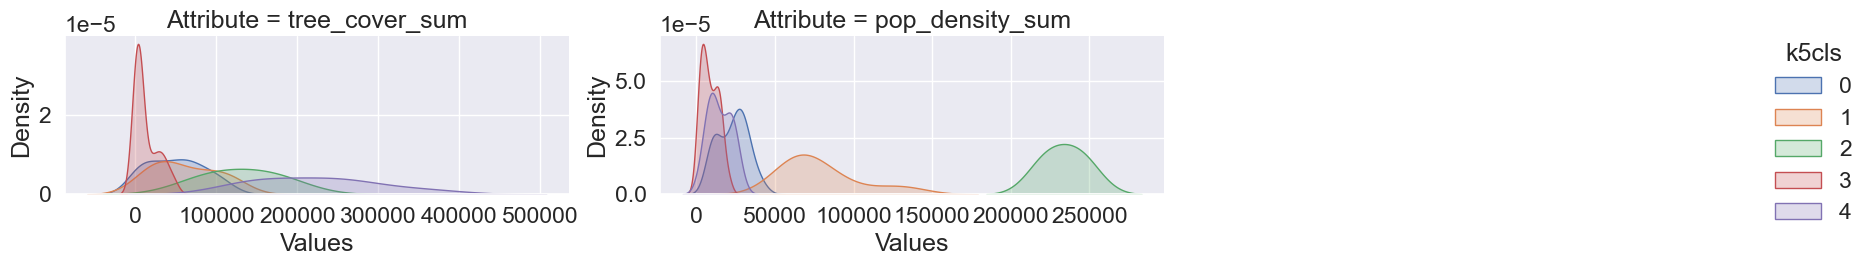

In [84]:
# Scale fonts to make them more readable
sn.set(font_scale=1.5)
# Setup the facets
facets = sn.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue="k5cls",
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)
# Build the plot from `sn.kdeplot`
_ = facets.map(sn.kdeplot, "Values", shade=True).add_legend()

Now lets turn to Agglomerative hierarchical clustering (AHC). Just another Clustering Algo

In [85]:
# Set seed for reproducibility
np.random.seed(0)
# Initialize the algorithm
model = AgglomerativeClustering(linkage="ward", n_clusters=5)
# Run clustering
model.fit(db_scaled)
# Assign labels to main data table
db["ward5"] = model.labels_

# As above, we can check the number of observations that fall within each cluster:
ward5sizes = db.groupby("ward5").size()
ward5sizes

ward5
0    70
1    13
2     7
3     2
4     4
dtype: int64

Average profiles of each of n AHC clusters

In [86]:
ward5means = db.groupby("ward5")[cluster_variables].mean()
ward5means.T.round(3)

ward5,0,1,2,3,4
tree_cover_sum,18621.300,98937.231,60978.857,130549.500,277150.500
pop_density_sum,14100.954,12398.561,78666.442,233854.281,16407.777


Reshape

In [88]:
# Index db on cluster ID
tidy_db = db.set_index("ward5")
# Keep only variables used for clustering
tidy_db = tidy_db[cluster_variables]
# Stack column names into a column, obtaining
# a "long" version of the dataset
tidy_db = tidy_db.stack()
# Take indices into proper columns
tidy_db = tidy_db.reset_index()
# Rename column names
tidy_db = tidy_db.rename(
    columns={"level_1": "Attribute", 0: "Values"}
)
# Check out result
tidy_db.head()

,ward5,Attribute,Values
0,4,tree_cover_sum,244746.000000
1,4,pop_density_sum,9711.628906
2,0,tree_cover_sum,10679.000000
3,0,pop_density_sum,14697.952148
4,0,tree_cover_sum,11838.000000


Density dists of each var in each cluster 

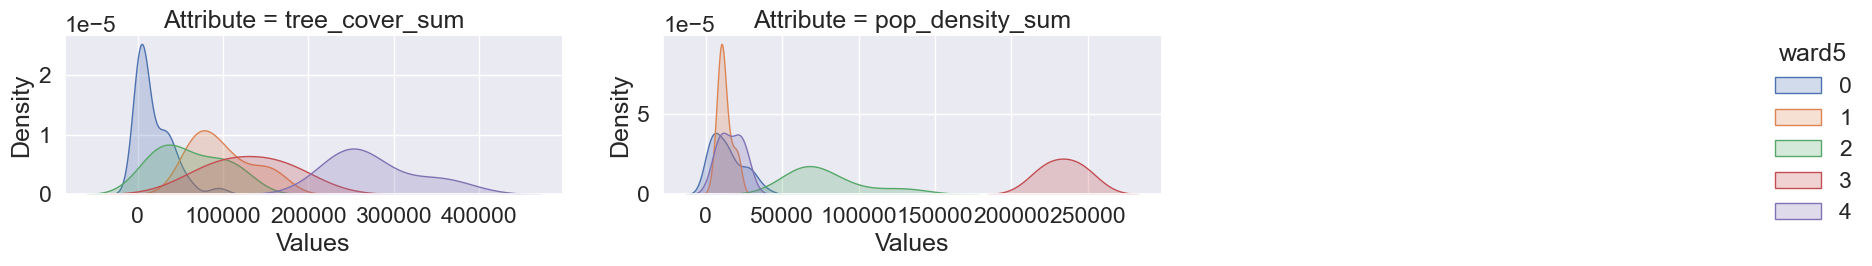

In [89]:
# Setup the facets
facets = sn.FacetGrid(
    data=tidy_db,
    col="Attribute",
    hue="ward5",
    sharey=False,
    sharex=False,
    aspect=2,
    col_wrap=3,
)
# Build the plot as a `sn.kdeplot`
facets.map(sn.kdeplot, "Values", shade=True).add_legend();

Juxtapose the K means and AHC clusters. Should give us comparable plots as these the two miltivarate clustering Algos share the same conceptual paradigm

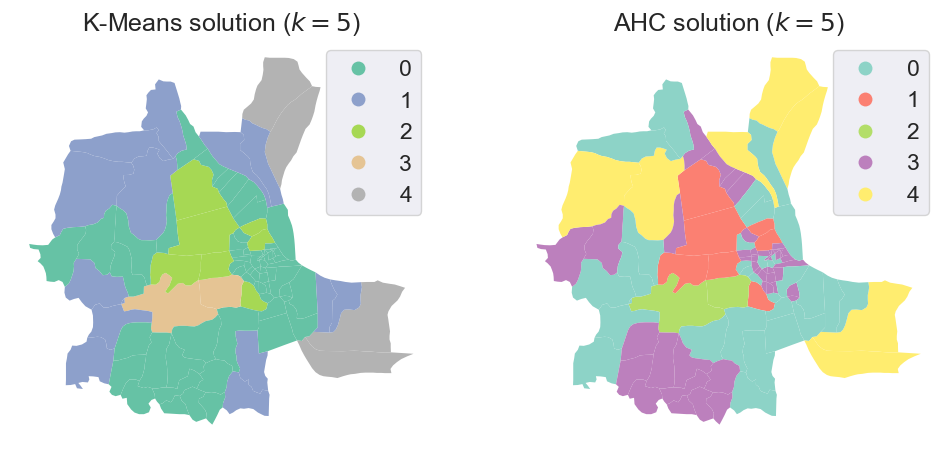

In [90]:
db["ward5"] = model.labels_
# Set up figure and ax
f, axs = plt.subplots(1, 2, figsize=(12, 6))

### K-Means ###
ax = axs[0]
# Plot unique values choropleth including
# a legend and with no boundary lines
db.plot(
    column="ward5",
    categorical=True,
    cmap="Set2",
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Add title
ax.set_title("K-Means solution ($k=5$)")

### AHC ###
ax = axs[1]
# Plot unique values choropleth including
# a legend and with no boundary lines
db.plot(
    column="k5cls",
    categorical=True,
    cmap="Set3",
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Add title
ax.set_title("AHC solution ($k=5$)")

# Display the map
plt.show()

## Regionalization: spatially constrained hierarchical clustering
We will take the AHC algorithm we have just used above and apply 
an additional spatial constraint or `contiguity contraint`. Use
`scikit-learn` to create spatial weights matrix but with the `connectivity` option.
This parameter will force the agglomerative algorithm to only allow observations to be grouped
in a cluster if they are also spatially connected. Now lets repeat the process with this additional contraints

In [91]:
# Set the seed for reproducibility
np.random.seed(123456)
# Specify cluster model with spatial constraint. AHC take connectivity option. The sparseness does the trick
model = AgglomerativeClustering(
    linkage="ward", connectivity=w.sparse, n_clusters=5
)
# Fit algorithm to the data
model.fit(db_scaled)

AgglomerativeClustering(connectivity=<96x96 sparse matrix of type '<class 'numpy.float64'>'
	with 562 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

Now plot the spatially contrained clusters

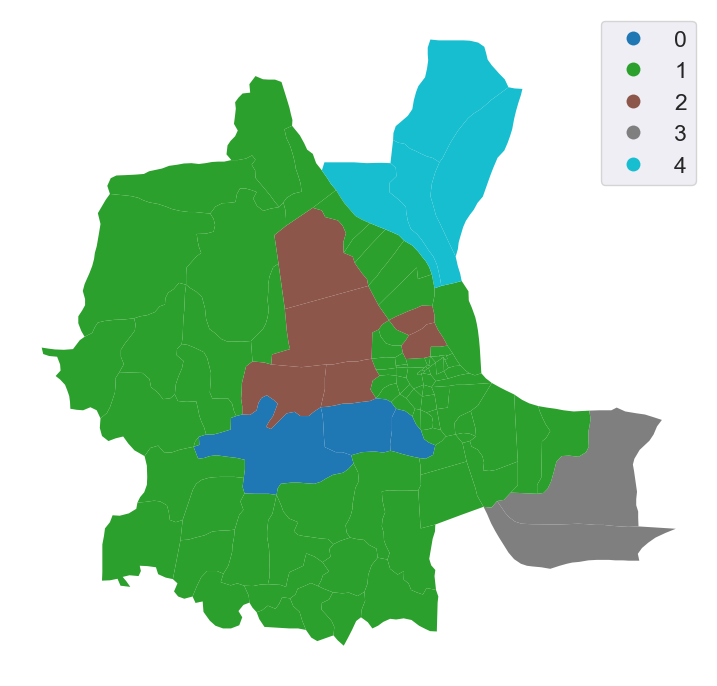

In [92]:
db["ward5wq"] = model.labels_
# Set up figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(
    column="ward5wq",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

##### Spatial k-nearest neighbor matrix
Lets test out another version of matrix. To do so, we use the same attribute data
but replace the Queen contiguity matrix with a spatial k-nearest neighbor matrix,
where each observation is connected to its four nearest observations, instead
of those it touches.

In [93]:
w = KNN.from_dataframe(db, k=4) #k for four nearest neighbors

In [95]:
# Set the seed for reproducibility
np.random.seed(123456)
# Specify cluster model with spatial constraint
model = AgglomerativeClustering(
    linkage="ward", connectivity=w.sparse, n_clusters=5
)
# Fit algorithm to the data
model.fit(db_scaled)

AgglomerativeClustering(connectivity=<96x96 sparse matrix of type '<class 'numpy.float64'>'
	with 384 stored elements in Compressed Sparse Row format>,
                        n_clusters=5)

Plot the result

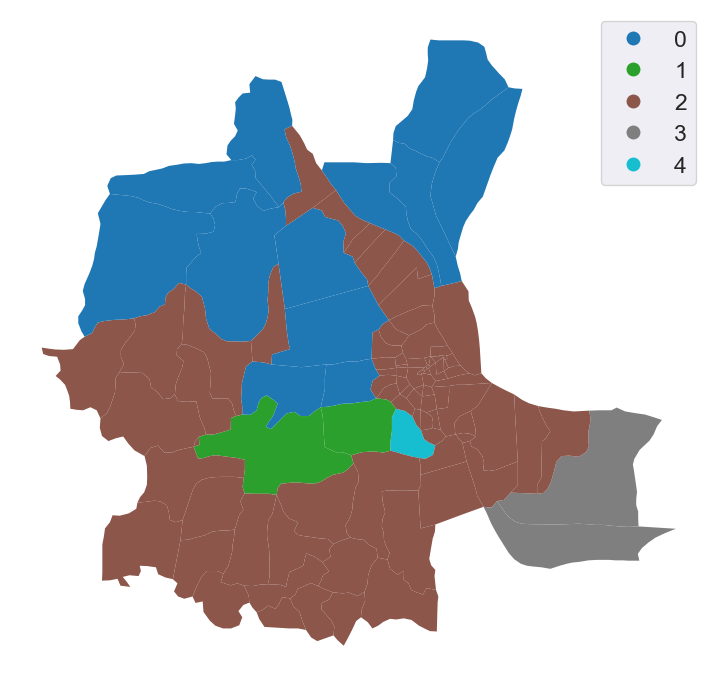

In [96]:
db["ward5wknn"] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth
# including a legend and with no boundary lines
db.plot(
    column="ward5wknn",
    categorical=True,
    legend=True,
    linewidth=0,
    ax=ax,
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

 #### Geographical coherence 
 It involves the "compactness" of a given shape. The most common of these measures is the isoperimetric quotient. Computing this, then, can be done directly from the area and perimeter of a region. Elongated shapes =0 and Neat regual polygons are closer to 1.

In [97]:
results = []
for cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn"):
    # compute the region polygons using a dissolve
    regions = db[[cluster_type, "geometry"]].dissolve(by=cluster_type)
    # compute the actual isoperimetric quotient for these regions
    ipqs = (
        regions.area * 4 * np.pi / (regions.boundary.length ** 2)
    )
    # cast to a dataframe
    result = ipqs.to_frame(cluster_type)
    results.append(result)
# stack the series together along columns
pd.concat(results, axis=1)

,k5cls,ward5,ward5wq,ward5wknn
0,0.060396,0.101384,0.358859,0.174763
1,0.239615,0.098858,0.153267,0.397003
2,0.397003,0.239615,0.307323,0.140468
3,0.076179,0.397003,0.474815,0.474815
4,0.126138,0.255977,0.532140,0.730417


### Feature coherence (goodness of fit). 
It often is inversely corr with compactness as computed above. Use sk learn for this. We used numpy for IPQ GC.

- `metrics.calinski_harabasz_score()` (CH): the within-cluster variance divided by the between-cluster variance.
- `metrics.silhouette_score()`: the average standardized distance from each observation to its "next best fit" cluster—the most similar cluster to which the observation is *not* currently assigned.

To compute these, each scoring function requires both the original data and the labels which have been fit. We'll compute the CH score for all the different clusterings below:

Recapping: Thus, the K-means will have the highest Calinski-Harabasz score, while the ward clustering will probably come second. The regionalizations will come *well* below the clusterings, too. As we said before, the improved geographical coherence comes at a pretty hefty cost in terms of feature goodness of fit.

In [98]:
ch_scores = []
for cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn"):
    # compute the CH score
    ch_score = metrics.calinski_harabasz_score(
        # using scaled variables
        robust_scale(db[cluster_variables]),
        # using these labels
        db[cluster_type],
    )
    # and append the cluster type with the CH score
    ch_scores.append((cluster_type, ch_score))

# re-arrange the scores into a dataframe for display
pd.DataFrame(
    ch_scores, columns=["cluster type", "CH score"]
).set_index("cluster type")

,CH score
cluster type,
k5cls,207.457529
ward5,185.822026
ward5wq,112.455067
ward5wknn,90.480152


### Solution similarity
From this, we can see that the K-means and Ward clusterings are the most self-similar, and the two regionalizations are slightly less similar to one another than the clusterings.

In [121]:
ami_scores = []
# for each cluster solution
for i_cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn"):
    # for every other clustering
    for j_cluster_type in ("k5cls", "ward5", "ward5wq", "ward5wknn"):
        # compute the adjusted mutual info between the two
        ami_score = metrics.adjusted_mutual_info_score(
            db[i_cluster_type], db[j_cluster_type]
        )
        # and save the pair of cluster types with the score
        ami_scores.append((i_cluster_type, j_cluster_type, ami_score))
# arrange the results into a dataframe
results = pd.DataFrame(
    ami_scores, columns=["source", "target", "similarity"]
)
# and spread the dataframe out into a square
# results.pivot("source", "target", "similarity")
result_pivoted= results.pivot( index= ["source"], columns= "target" , values=["similarity"])
result_pivoted

similarity                              
target         k5cls     ward5 ward5wknn   ward5wq
source                                            
k5cls       1.000000  0.603910  0.418451  0.495994
ward5       0.603910  1.000000  0.534482  0.645836
ward5wknn   0.418451  0.534482  1.000000  0.606935
ward5wq     0.495994  0.645836  0.606935  1.000000

In [ ]:

def clip_and_export_raster(input_gpdf, raster , out_raster, zonal_stat_var):
    Vector=input_gpdf
    with rasterio.open(raster) as src:
        Vector=Vector.to_crs(src.crs)
        # print(f'Gdf srs: {Vector.crs}')
        out_image, out_transform=mask(src,Vector.geometry,crop=True)
        out_meta=src.meta.copy() # copy the metadata of the source DEM
        
    out_meta.update({
        "driver":"Gtiff",
        "height":out_image.shape[1], # height starts with shape[1]
        "width":out_image.shape[2], # width starts with shape[2]
        "transform":out_transform
    })
                
    with rasterio.open(out_raster,'w',**out_meta) as dst:
        dst.write(out_image)

    # add zonal stats to the hexbin gpd dataframe and replace nans with 0 
    hexbins_projected[zonal_stat_var] = zonal_stats(hexbins_projected, out_raster ,stats='mean')
    hexbins_projected[zonal_stat_var] = [item['mean'] for item in hexbins_projected[zonal_stat_var]]
    hexbins_projected[zonal_stat_var].fillna(0,inplace=True)
    max=int(hexbins_projected.loc[hexbins_projected[zonal_stat_var].idxmax()][zonal_stat_var])
    
    return hexbins_projected , max

In [ ]:
# Change colormap by truncating
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [ ]:
def zonal_stats_tree_cover(ee , EPSG_str):

    tree_cover=ee.ImageCollection("projects/sat-io/open-datasets/GFCC30TC") \
        .limit(1, 'system:time_start', False).first().clip(fc_filtered)

    tif = os.path.join(rasters, 'tree_cover_projected.tif')
    geemap.ee_export_image(
        tree_cover, filename=tif,  
        crs=EPSG_str,
        # crs_transform=crs_transform,
        scale=30, region=region, file_per_band=False
    )

    # add zonal stats to the hexbin gpd dataframe and replace nans with 0 
    hexbins_projected['tree_cover_sum'] = zonal_stats(hexbins_projected, tif ,stats='sum')
    hexbins_projected['tree_cover_sum'] = [item['sum'] for item in hexbins_projected['tree_cover_sum']]
    hexbins_projected['tree_cover_sum'].fillna(0,inplace=True)
    max=int(hexbins_projected.loc[hexbins_projected['tree_cover_sum'].idxmax()]['tree_cover_sum'])
    
    return hexbins_projected , max

In [ ]:
def clipToCol(image):
  """clip gee collection
  args:
      image: Image collection
  returns:
    ee-collection: Clipped image collection
   
   """
  return image.clip(fc_filtered)

In [ ]:
def export_map(map_dir, hexagons, crs,cmap,  visualize_column, title):
    ax = hexagons.to_crs(crs).plot(figsize=(12, 12) ,vmin=0,  vmax=int(max/4) , \
                                   alpha=0.6, column=visualize_column, \
                                    cmap=cmap,legend=True, \
                                        legend_kwds={'shrink': 0.77, 'orientation': 'vertical', \
                                                      'location': 'right', 'label': f'{title}', \
                                                        'pad':0.009})

    gdf_WA.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    gdf_subcity.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='blue',alpha=0.2)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,  crs=crs) 
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels,   crs=crs) # zoom=13
    plt.title(f'{title}',fontsize=20)
    plt.xticks([])
    plt.yticks([])
        
    ax.figure.set_size_inches(12, 12)
    plt.tight_layout()
    ax.figure.savefig(f"{map_dir}/{city}_{visualize_column}_truncated_cmap_max_div_4.png")


In [ ]:
def export_map_uh(map_dir, hexagons, crs,cmap,  visualize_column, title):
    ax = hexagons.to_crs(crs).plot(figsize=(12, 12) , \
                                   alpha=0.6, column=visualize_column, \
                                    cmap=cmap,legend=True, \
                                        legend_kwds={'shrink': 0.77, 'orientation': 'vertical', \
                                                      'location': 'right', 'label': f'{title}', \
                                                        'pad':0.009})

    gdf_WA.to_crs(crs).plot(ax=ax,facecolor='none',edgecolor='k',alpha=0.2)
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLite,  crs=crs) 
    cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels,   crs=crs) # zoom=13
    plt.title(f'{title}',fontsize=20)
    plt.xticks([])
    plt.yticks([])
        
    ax.figure.set_size_inches(12, 12)
    plt.tight_layout()
    ax.figure.savefig(f"{map_dir}/{city}_{visualize_column}_truncated_cmap_max_div_4.png")


In [ ]:
def zonal_stats_tree_cover_esa_vito(ee , EPSG_str):

    tree_cover=ee.ImageCollection("ESA/WorldCover/v100") \
        .limit(1, 'system:time_start', False).first().clip(fc_filtered).eq(10) #trees only
        # .limit(1, 'system:time_start', False).select(10).first().clip(fc_filtered) #trees only

    tif = os.path.join(rasters, 'tree_cover_projected.tif')
    geemap.ee_export_image(
        tree_cover, filename=tif,  
        crs=EPSG_str,
        # crs_transform=crs_transform,
        scale=10, region=region, file_per_band=False
    )

    # add zonal stats to the hexbin gpd dataframe and replace nans with 0 
    hexbins_projected['tree_cover_sum_esa'] = zonal_stats(hexbins_projected, tif ,stats='sum')
    hexbins_projected['tree_cover_sum_esa'] = [item['sum'] for item in hexbins_projected['tree_cover_sum_esa']]
    hexbins_projected['tree_cover_sum_esa'].fillna(0,inplace=True)
    max=int(hexbins_projected.loc[hexbins_projected['tree_cover_sum_esa'].idxmax()]['tree_cover_sum_esa'])
    
    return hexbins_projected , max


In [ ]:
def zonal_stats_pop_density(ee , EPSG_str):
    #  Define WorldPop & clip using function 
    pop_density = ee.ImageCollection("WorldPop/GP/100m/pop").map(clipToCol). \
                    filterDate('2020').select('population').mosaic()

    tif = os.path.join(rasters, 'pop_density_projected.tif')
    geemap.ee_export_image( pop_density, 
                           filename=tif,  
                           crs=EPSG_str,
                           # crs_transform=crs_transform,
                           scale=100, 
                           region=region, 
                           file_per_band=False
                           )

    # add zonal stats to the hexbin gpd dataframe and replace nans with 0 
    hexbins_projected['pop_density_sum'] = zonal_stats(hexbins_projected, tif ,stats='sum')
    hexbins_projected['pop_density_sum'] = [item['sum'] for item in hexbins_projected['pop_density_sum']]
    hexbins_projected['pop_density_sum'].fillna(0,inplace=True)
    max=int(hexbins_projected.loc[hexbins_projected['pop_density_sum'].idxmax()]['pop_density_sum'])
    
    return hexbins_projected , max

In [ ]:
def calculate_trees_to_people_ratio(hexbins_projected , tree_cover_type):
    hexbins_projected[f'{tree_cover_type}_div_people']= hexbins_projected[[tree_cover_type]].div(hexbins_projected.pop_density_sum, axis=0) #.astype(int)
    hexbins_projected[f'{tree_cover_type}_div_people']= hexbins_projected[f'{tree_cover_type}_div_people'].apply("int64")
    max=int(hexbins_projected.loc[hexbins_projected[f'{tree_cover_type}_div_people'].idxmax()][f'{tree_cover_type}_div_people'])
    return hexbins_projected , max


In [ ]:
def get_uh_raster_dirs(input_raster_dir):
    raster_dirs=  [x[1] for x in os.walk(input_raster_dir)] # ['Present', 'SSP119' , 'SSP370']
    raster_dirs = [x for x in raster_dirs if len(x)>0]
    raster_dirs = list(np.concatenate(raster_dirs))
    return raster_dirs

In [ ]:
def create_maps_from_vito_rasters():
    for subdir in raster_dirs:
        extension = '.tif'
        for root, dirs_list, files_list in os.walk( os.path.join(input_raster_dir, subdir)):
            for file_name in files_list:
                if os.path.splitext(file_name)[-1] == extension:
                    file_name_path = os.path.join(root, file_name)
                    file_name = os.path.splitext(file_name)[0]
                    file_name = ' '.join(file_name.split("_")[:-2])
                    # print(file_name,  file_name_path)
                    rst = file_name_path 
                    #clip and export rasters 
                    out_rst = f'{rasters}/{file_name} {subdir}_clipped.tif'
                    hexbins_projected , max= clip_and_export_raster(input_gpdf=gdf_WA, raster=rst , out_raster=out_rst, zonal_stat_var=file_name)
                    cmap = plt.get_cmap('RdYlGn', 10)
                    cmap = truncate_colormap(cmap, 0.1, 1)
                    export_tree_cover= export_map_uh(map_dir= maps, hexagons=hexbins_projected, crs=WGS84, cmap=cmap , visualize_column=file_name, title=file_name)


Generating URL ...
Please wait ...
Data downloaded to C:\Users\Aziz\Dropbox\CRP\UHI\output\rasters\tree_cover_projected.tif


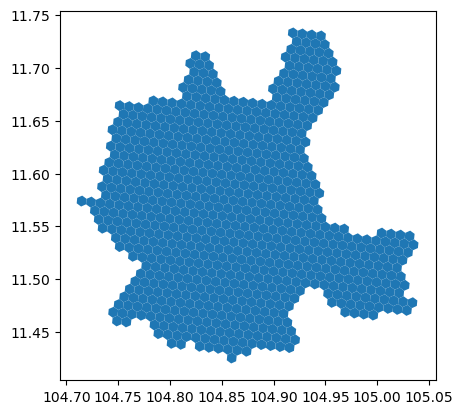

In [ ]:
if __name__ == "__main__":
    fc_filtered  , region , hexbins_projected= create_hexbins_and_geom_features(gdf_WA, hexbin_res=8, WGS84=WGS84)
    # hexbins_projected , max=  zonal_stats_tree_cover_esa_vito(ee , EPSG_str)
    # cmap = plt.get_cmap('RdYlGn', 10)
    # cmap = truncate_colormap(cmap, 0.1, 1)
    # export_tree_cover= export_map(map_dir= maps, hexagons=hexbins_projected, crs=WGS84, cmap=cmap , visualize_column='tree_cover_sum_esa', title="Tree Cover (ESA 10 meters)")
    # hexbins_projected , max= zonal_stats_tree_cover(ee , EPSG_str)
    # export_tree_cover= export_map(map_dir= maps, hexagons=hexbins_projected, crs=WGS84, cmap=cmap , visualize_column='tree_cover_sum', title="Tree Cover (Landsat 30 meters)")
    # hexbins_projected , max= zonal_stats_pop_density(ee , EPSG_str)
    # export_pop_density= export_map(map_dir= maps, hexagons=hexbins_projected, crs=WGS84, cmap=cmap , visualize_column='pop_density_sum' , title="Population (Worldpop 100 meters)")
    # tree_cover_type= 'tree_cover_sum'
    # hexbins_projected , max=calculate_trees_to_people_ratio(hexbins_projected , tree_cover_type=tree_cover_type)
    # tree_cover_type= f'{tree_cover_type}_div_people'
    # export_tree_cover= export_map(map_dir= maps, hexagons=hexbins_projected, crs=WGS84, cmap=cmap , visualize_column=tree_cover_type, title="Tree cover(Landsat) to population ratio")
    # tree_cover_type= 'tree_cover_sum_esa'
    # hexbins_projected , max=calculate_trees_to_people_ratio(hexbins_projected , tree_cover_type=tree_cover_type)
    # tree_cover_type= f'{tree_cover_type}_div_people'
    # export_tree_cover= export_map(map_dir= maps, hexagons=hexbins_projected, crs=WGS84, cmap=cmap , visualize_column=tree_cover_type, title="Tree cover(ESA) to population ratio")
    zonal_stats_tree_cover= zonal_stats_tree_cover_for_subcity(ee , EPSG_str,region=region, subcity_shapefile=gdf_subcity)


In [ ]:
zonal_stats_tree_cover['Percentile Rank']

TypeError: tuple indices must be integers or slices, not str

In [ ]:
if run_uh_analysis:
    input_raster_dir = f'{base_dir}/data/Phnom Penh/Geotiffs'
    raster_dirs= get_uh_raster_dirs(input_raster_dir)
    create_maps_from_vito_rasters= create_maps_from_vito_rasters()
